## Attention linking PoC: Part II

This is an overview of the research of utilizing attention in aim for more accurate and transparent Information Retrieval.

### Hyphotesis:

Transformers' attention reflects the internal relations of entities in the text and hence does reflect the importance of the pieces of text.

### Experiment Methodology:

As shown in `attention_linking.ipynb`, the attention heads are variously good at dinstingiushing the keyphrases of the texts.

Now, given that we know how well the attention itself does, we'll methodically select a subset of them to predict the importance of the tokens.

- We'll select a certain number of heads and will do token classification based on their attentions as features.

- We'll order the heads from best- to worst-distinguishing, according to the criteria: **cross-entropy to the target**. We'll be continuously increasing a number of heads from best to worst and will observe, how they perform on aforementioned token classification.

### Evaluation

We'll measure an accuracy of token classification, based on selected heads' attention, on validation set. We'll plot this accuracy and seek for optimum.

### Outputs

We'll see, how well best-performing heads can do. Eventually, we will compare this result with token classification of the whole Transformers' models.

The best-performing methodology will be used for kephrase selection and respective weighting of the pieces of text in IRSystem.

In [1]:
from common import *
import random

In [3]:
model_id = "gpt"
firstn = 100

tokenizer, model = get_tokenizer_model(model_id)
features_all = pd.DataFrame()

for kw_key, ktext in tqdm(tuple(ktexts.items())[:firstn], desc=model_id):
    wpieces, attention = get_attentions(ktext['text'], model, tokenizer)
    
    keywd_mask = get_keyphrases_mask(wpieces, [kw for kw in ktext['keywords'] if len(kw)>2], tokenizer).bool()
    records = []
    negative_records = []
    # consider all heads 
    for l_i, h_i in [(l, h) for l in range(12) for h in range(12)]:
        for wpiece, head_weights in zip(wpieces[keywd_mask], attention[l_i][0][h_i][keywd_mask]):
            records.append({"wordpiece": wpiece, "layer":l_i, "head":h_i, "weight": head_weights.max().item(), 
                            "is_kw": True, "kname": kw_key, "model": model_id, "is_max": True})
            records.append({"wordpiece": wpiece, "layer":l_i, "head":h_i, "weight": head_weights.mean().item(), 
                            "is_kw": True, "kname": kw_key, "model": model_id, "is_max": False})
        # add the same number of negative samples, but for the same layers and heads
        for wpiece, head_weights in random.sample(list(zip(wpieces[~keywd_mask], attention[l_i][0][h_i][~keywd_mask])), 
                                                  k=keywd_mask.sum().item()):
            negative_records.append({"wordpiece": wpiece, "layer":l_i, "head":h_i, "weight": head_weights.max().item(), 
                                     "is_kw": False, "kname": kw_key, "model": model_id, "is_max": True})
            negative_records.append({"wordpiece": wpiece, "layer":l_i, "head":h_i, "weight": head_weights.mean().item(), 
                                     "is_kw": False, "kname": kw_key, "model": model_id, "is_max": False})

    features_all = pd.concat([features_all, pd.DataFrame(records), pd.DataFrame(negative_records)], axis=0)
#     return features_all

gpt: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


In [4]:
links_df = features_all

<AxesSubplot:>

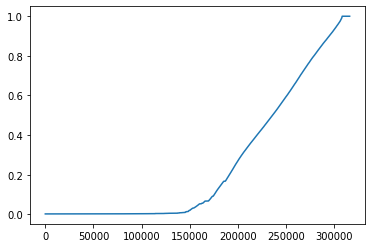

In [5]:
# why are most of the weights the same?
links_df.weight.sort_values().reset_index(drop=True).plot()

In [6]:
def get_filter(ref_df: pd.DataFrame, model_id: str, kw_key: str, layer: int, head: int, max_pooling: bool, target_is_kw: bool):
    return (ref_df.model == model_id) & \
           (ref_df.kname == kw_key) & \
           (ref_df.layer == layer) & \
           (ref_df["head"] == head) & \
           (ref_df.is_max == max_pooling) & \
           ref_df.is_kw == target_is_kw

In [7]:
samples = []
model_id = 'gpt'
for kw_key in tqdm(links_df.kname.unique()):
    for target in [True, False]:
        features = {}
        for pooling_key, is_max_pooling in zip(["max", "mean"], [True, False]):
            for l_i, h_i in [(l, h) for l in range(12) for h in range(12)]:
                f = get_filter(links_df, model_id, kw_key, l_i, h_i, is_max_pooling, target)
                features["l_%s_h_%s_%s" % (l_i, h_i, pooling_key)] = links_df[f].iloc[0]["weight"]
        samples.append({**features, "target": target})
samples_df = pd.DataFrame(samples)
samples_df.head()

100%|██████████| 86/86 [38:49<00:00, 27.09s/it]


,l_0_h_0_max,l_0_h_1_max,l_0_h_2_max,l_0_h_3_max,l_0_h_4_max,l_0_h_5_max,l_0_h_6_max,l_0_h_7_max,l_0_h_8_max,l_0_h_9_max,...,l_11_h_3_mean,l_11_h_4_mean,l_11_h_5_mean,l_11_h_6_mean,l_11_h_7_mean,l_11_h_8_mean,l_11_h_9_mean,l_11_h_10_mean,l_11_h_11_mean,target
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,0.006849,True
1,0.006849,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False
2,0.031373,0.760432,0.024475,0.817676,0.474607,0.878085,0.033988,0.254342,0.040207,0.025643,...,0.004444,0.004444,0.004444,0.004444,0.004444,0.004444,0.004444,0.004444,0.004444,True
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.001953,0.001953,0.001953,0.001953,0.001953,0.001953,0.001953,0.001953,0.001953,True


In [8]:
samples_df.shape

(172, 289)

Text(0, 0.5, 'Wordpiece attention value')

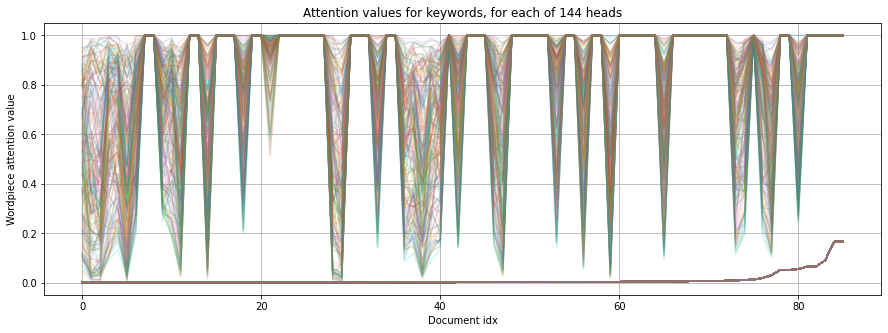

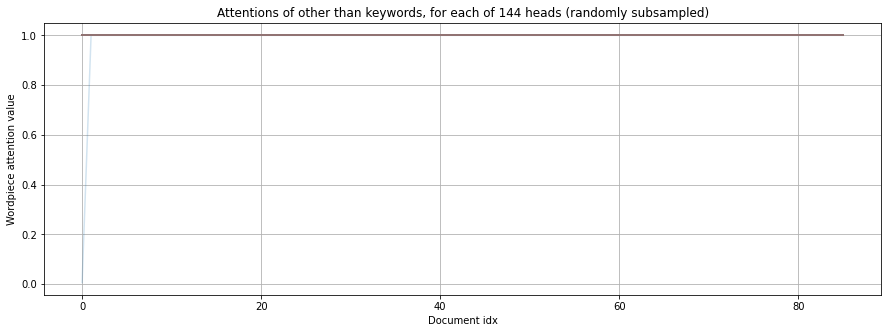

In [41]:
ax = samples_df[samples_df.target].sort_values(by="l_6_h_2_mean").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attention values for keywords, for each of 144 heads")
ax.set_xlabel("Document idx")
ax.set_ylabel("Wordpiece attention value")

ax2 = samples_df[~samples_df.target].sort_values(by="l_6_h_2_mean").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attentions of other than keywords, for each of 144 heads (randomly subsampled)")
ax2.set_xlabel("Document idx")
ax2.set_ylabel("Wordpiece attention value")

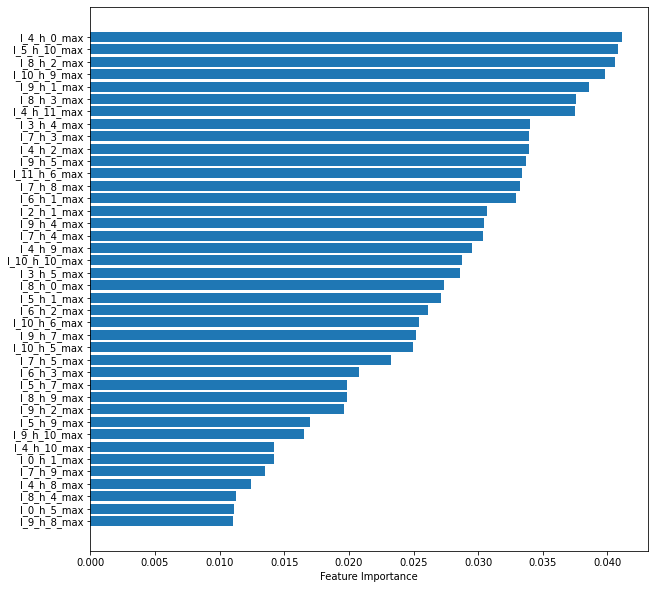

In [44]:
# MAX strategy
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

X_cols = ["l_%s_h_%s_%s" % (l, h, p) for l in range(12) for h in range(12) for p in ["max"]] 

clf = LogisticRegression(random_state = 0)
clf.fit(samples_df[X_cols], samples_df["target"])

feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = (np.arange(sorted_idx.shape[0]) + .5)[:top_features]

featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx][:top_features], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_cols)[sorted_idx][:top_features])
featax.set_xlabel('Feature Importance')
plt.show()

In [45]:
from sklearn.metrics import classification_report
clf.fit(samples_df[X_cols].iloc[:120], samples_df["target"].iloc[:120])
preds = clf.predict(samples_df[X_cols].iloc[120:])
trues = samples_df["target"].iloc[120:]
print(classification_report(trues, preds))

              precision    recall  f1-score   support

       False       0.68      1.00      0.81        26
        True       1.00      0.54      0.70        26

    accuracy                           0.77        52
   macro avg       0.84      0.77      0.76        52
weighted avg       0.84      0.77      0.76        52



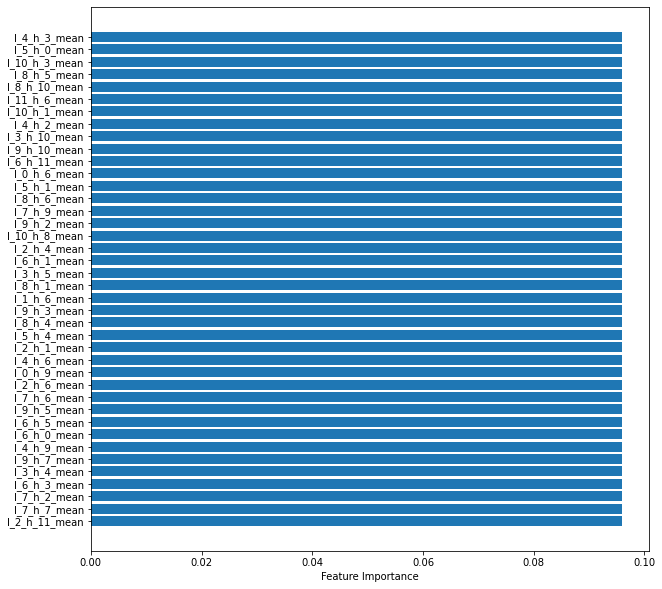

In [47]:
# MEAN strategy
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

X_cols = ["l_%s_h_%s_%s" % (l, h, p) for l in range(12) for h in range(12) for p in ["mean"]] 

clf = LogisticRegression(random_state = 0)
clf.fit(samples_df[X_cols], samples_df["target"])

feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = (np.arange(sorted_idx.shape[0]) + .5)[:top_features]

featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx][:top_features], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_cols)[sorted_idx][:top_features])
featax.set_xlabel('Feature Importance')
plt.show()

In [48]:
from sklearn.metrics import classification_report
clf.fit(samples_df[X_cols].iloc[:120], samples_df["target"].iloc[:120])
preds = clf.predict(samples_df[X_cols].iloc[120:])
trues = samples_df["target"].iloc[120:]
print(classification_report(trues, preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        26
        True       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

